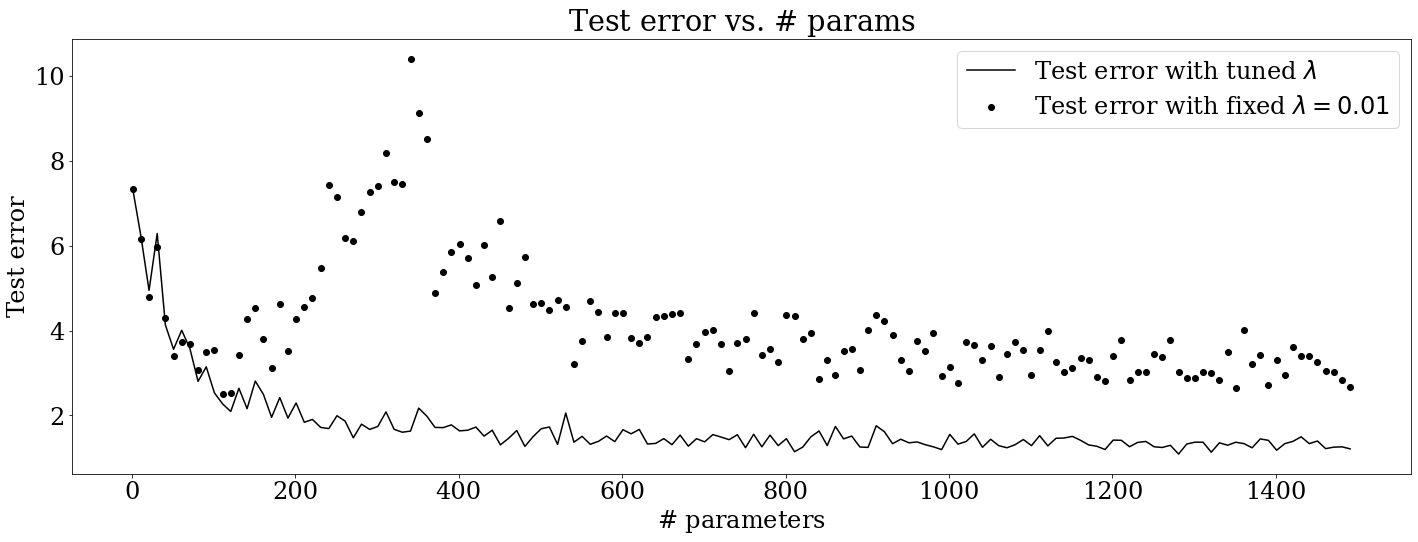

In [41]:
from math import sqrt

import matplotlib.pyplot as plt
import numpy as np


"""
Step 1 : Generate Toy data
"""

d = 35
n_train, n_val, n_test = 300, 60, 30
np.random.seed(0)
beta = np.random.randn(d)
beta_true = beta / np.linalg.norm(beta)

# Generate and fix training data
X_train = np.array(
    [np.random.multivariate_normal(np.zeros(d), np.identity(d)) 
                    for _ in range(n_train)])

Y_train = X_train @ beta_true + np.random.normal(loc = 0.0, 
                                                 scale = 0.5, 
                                                 size = n_train)

# Generate and fix validation data (for tuning lambda). 
X_val = np.array(
    [np.random.multivariate_normal(np.zeros(d), np.identity(d)) 
                  for _ in range(n_val)])
Y_val = X_val @ beta_true 

# Generate and fix test data
X_test = np.array(
    [np.random.multivariate_normal(np.zeros(d), np.identity(d)) 
                   for _ in range(n_test)])
Y_test = X_test @ beta_true 


"""
Step 2 : Solve the problem
"""    

def solve_lsqr(X, y, lamda):
    return  np.linalg.solve(np.dot(X.T, X) 
                            + lamda * np.identity(X.shape[1]), X.T @ y)

def get_error(tilde_x, y, theta) :
    return np.linalg.norm(tilde_x @ theta - y)

def ReLU(x) :
    return np.where(np.asarray(x) > 0, x, 0)


lambda_list = [2 ** i for i in range(-6, 6)]
num_params = np.arange(1,1501,10)

errors_opt_lambda = []
errors_fixed_lambda = []

for p in num_params :

    input_dim, hidden_dim = d, p

    # STEP 1 : Find THETA
    weight_matrix = np.random.normal(loc=0.0, 
                                     scale=1 / sqrt(hidden_dim), 
                                     size=(hidden_dim, input_dim))
    
    x_tilde = ReLU(X_train @ weight_matrix.T)
    theta = solve_lsqr(x_tilde, Y_train, 0.01)

    
    # STEP 2 : Test for lambda = 0.01
    X_test_tilde = ReLU(X_test @ weight_matrix.T)
    error = get_error(X_test_tilde, Y_test, theta)
    errors_fixed_lambda.append(error)

    
    # STEP 3 : Find OPT-lambda
    opt_lambda_ = 0.01
    min_error = 999999
    for lambda_ in lambda_list:

        # STEP 3-1 : Tune Theta for lambda_
        theta = solve_lsqr(x_tilde, Y_train, lambda_)

        # STEP 3-2 : Test for lambda using validation set
        X_val_tilde = ReLU(X_val @ weight_matrix.T)
        error = get_error(X_val_tilde, Y_val, theta)
        if error < min_error :
            min_error = error
            opt_lambda_ = lambda_

    # STEP 4 : Find OPT-theta for OPT-lambda
    theta = solve_lsqr(x_tilde, Y_train, opt_lambda_)

    # STEP 5 : Test for OPT-lambda
    X_test_tilde = ReLU(X_test @ weight_matrix.T)
    error = get_error(X_test_tilde, Y_test, theta)
    errors_opt_lambda.append(error)


"""
Step 3 : Plot the results
"""    

plt.figure(figsize = (24, 8))
plt.rc('text', usetex = False)
plt.rc('font', family = 'serif')
plt.rc('font', size = 24)


plt.scatter(num_params, errors_fixed_lambda, color = 'black', 
            label = r"Test error with fixed $\lambda = 0.01$",)
plt.legend()

plt.plot(num_params, errors_opt_lambda, 'k', 
         label = r"Test error with tuned $\lambda$")

plt.legend()
plt.xlabel(r'$\#$ parameters')
plt.ylabel('Test error')
plt.title(r'Test error vs. $\#$ params')

plt.savefig('double_descent.png')
plt.show()